(900, 32, 32, 3)
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_235 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_141 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_142 (Bat (None, 16, 16, 32)        128       
_________________________________________________________________
up_sampling2d_47 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 

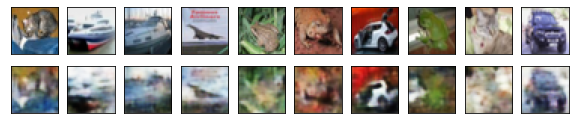

In [49]:
import numpy as np
import math
import cv2
import tensorflow as tf
import pandas
from keras.layers import Conv2D, UpSampling2D, BatchNormalization
from keras.models import Sequential
from keras.datasets import cifar10
import matplotlib.pyplot as plt


(x_train, _), (x_test, _) = cifar10.load_data()
(x_train, _) = (x_train[:900],_[:900])
print(x_train.shape)
(x_test, _) = (x_test[:100],_[:100])
x_train = x_train/255
x_test = x_test/255


model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()

num_epochs = 70
NOISE = 0.3     # Set to 0 for a regular (non-denoising...) autoencoder
for i in range(num_epochs):
    noise = np.random.normal(0, NOISE, x_train.shape)
    model.fit(x_train + noise, x_train, epochs=1, batch_size=100)


noise = np.random.normal(0, NOISE, x_test.shape)
pred_imgs = model.predict(x_test + noise)


def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

print("PSNR = ", calculate_psnr(x_test[10], pred_imgs[10]))
print("SSIM = ", calculate_ssim(x_test[10], pred_imgs[10]))

n = 10

plt.figure(figsize=(10, 2))
for i in range(n): 
 ax = plt.subplot(2, n, i + 1)
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 plt.imshow(x_test[i].reshape(32, 32, 3))

 plt.gray()

 

 ax = plt.subplot(2, n, i + 1 + n)
 ax.get_xaxis().set_visible(False)
 ax.get_yaxis().set_visible(False)
 plt.imshow(pred_imgs[i].reshape(32, 32, 3))

plt.show()

# plt.imshow(sbscompare(x_test + noise, pred_imgs, 20, 20))
# plt.axis('off')
# plt.rcParams["figure.figsize"] = [60,60]
# plt.show()

